### 2 - Métodos de suavização e alguns modelos simples

Terminamos falando sobre Simple Moving Average. Vamos relembrar:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Vamos carregar os dados de passageiros em viagens aéreas
df = pd.read_csv('airline_passengers.csv', parse_dates=True, index_col='Month')
df.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


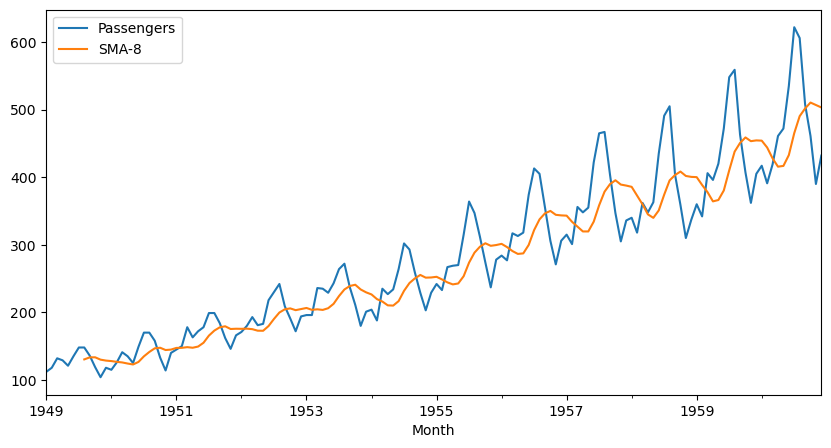

In [3]:
df['SMA-8'] = df['Passengers'].rolling(8).mean()
df.plot(figsize=(10,5));

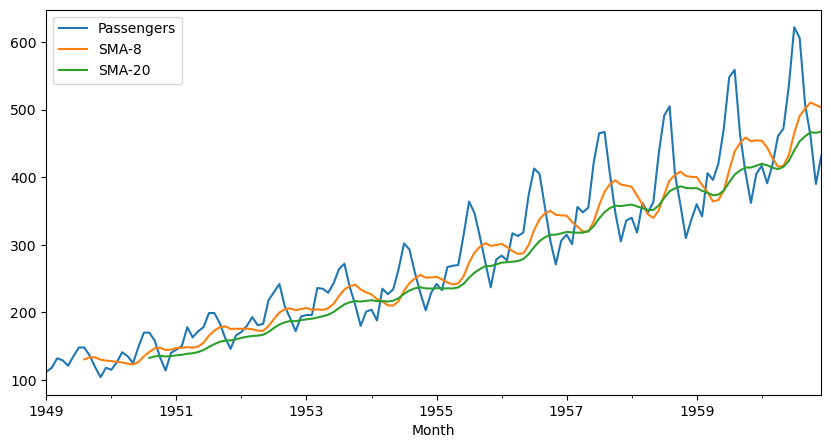

In [4]:
df['SMA-20'] = df['Passengers'].rolling(20).mean()
df.plot(figsize=(10,5));

#### Exponential Weighted Moving Average (EWMA)

Também conhecido como **suavização exponencial** ou **filtro passa-baixa**.

Temos $\overline{x}_t = \frac{\sum_{\tau=0}^{t}x_\tau}{t}$ a média aritmética. Fazendo manipulações simples com a fórmula da média aritmética teremos $\overline{x}_t = (1-\frac{1}{t})\overline{x}_{t-1} + \frac{x_t}{t}$.


O modelo EWMA é calculado como: $\overline{x}_t = \alpha x_t + (1-\alpha)\overline{x}_{t-1}$ com $0 \leq \alpha \leq 1$.

**Ideia do modelo:** Quando consideramos a média aritmética $\overline{x}_t = \frac{\sum_{\tau=0}^{t}x_\tau}{t}$ cada informação nova tem menos importância. O modelo EWMA tenta corrigir isso fixando um peso $\alpha$ a cada nova informação e não um peso $\frac{1}{t}$ que reduz com o aumento da série.


Se expandirmos de forma recursiva a equação $\overline{x}_t = \alpha x_t + (1-\alpha)\overline{x}_{t-1}$ terminaremos com $\overline{x}_t = (1-\alpha)^t \overline{x}_0 + \alpha \sum_{\tau=0}^{t-1} x_{t-\tau} (1-\alpha)^{\tau}$ e daí temos uma ideia da origem do nome do modelo.

In [5]:
df = pd.read_csv('airline_passengers.csv', parse_dates=True, index_col='Month')

In [6]:
# quanto maior o valor de alpha mais peso dou à medição atual x_t
alpha=0.2

# Colocamos adjust = False, caso contrário o Pandas faz um cálculo diferente do que queremos
df['EWMA'] = df['Passengers'].ewm(alpha=alpha, adjust=False).mean()
df[['EWMA']].tail(10)

,EWMA
Month,
1960-03-01,417.834999
1960-04-01,426.467999
1960-05-01,435.574399
1960-06-01,455.459520
1960-07-01,488.767616
1960-08-01,512.214093
1960-09-01,511.371274
1960-10-01,501.297019
1960-11-01,479.037615


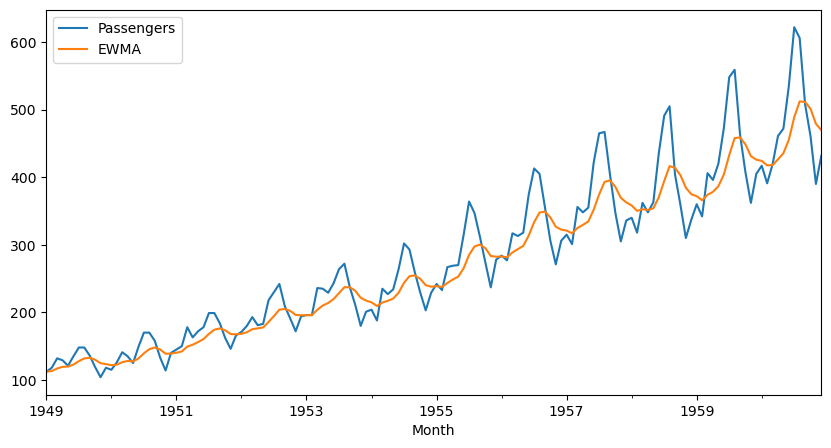

In [7]:
df.plot(figsize=(10,5));

In [8]:
# Fazendo a conta manualmente para ver se o Pandas está correto:

manual_ewma = []
for x in df.Passengers:
    # quando a lista está vazia então só adiciono a primeira observação
    if len(manual_ewma)==0:
        manual_ewma.append(x)
    else:
        manual_ewma.append((1-alpha)*manual_ewma[-1] + alpha*x)
        
print(manual_ewma[-10:])

[417.8349991773617, 426.46799934188937, 435.57439947351156, 455.45951957880925, 488.7676156630474, 512.2140925304379, 511.3712740243504, 501.2970192194803, 479.03761537558427, 469.6300923004675]


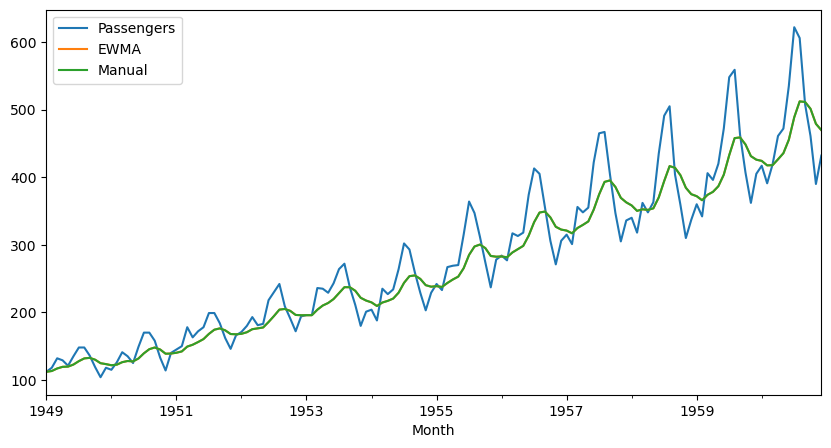

In [9]:
df['Manual'] = manual_ewma
df.plot(figsize=(10,5));

In [10]:
df.drop('Manual', axis=1, inplace=True)

#### Simple Exponential Smoothing

Agora vamos usar o que começamos a construir anteriormente para tentar fazer previsões.

Usando a notação do EWMA temos o modelo de previsão como $\hat{y}_{t+1\vert t} = \alpha y_t + (1-\alpha)\hat{y}_{t \vert t-1}$

**Modelo na forma de componentes:**

Forecast Equation: $\hat{y}_{t+h\vert t} = l_t$, para $h=1,2,3,\ldots$

Smoothing Equation: $l_t = \alpha y_t + (1-\alpha) l_{t-1}$

E vemos que nossa previsão é um valor constante para qualquer quantidade $h$ de passos a frente. O que faz sentido, pois estamos usando somente o modelo EWMA, ou seja, um tipo de média sem nenhuma informação extra.

In [11]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

ses = SimpleExpSmoothing(df['Passengers'])

C:\Users\hugos\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [12]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [13]:
df.index.freq = 'MS'

In [14]:
ses = SimpleExpSmoothing(df['Passengers'], initialization_method = 'legacy-heuristic')

In [15]:
res = ses.fit(smoothing_level = alpha, optimized = False)

In [16]:
# Agora vamos fazer previsão
df['SES'] = res.fittedvalues 
# Ou podemos usar o código definindo datas específicas: df['SES'] = res.predict(start = df.index[0], end = df.index[-1])

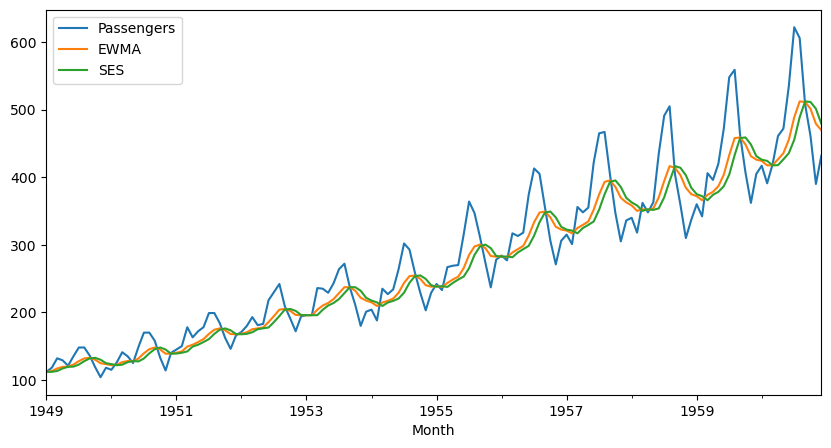

In [17]:
df.plot(figsize=(10,5));

Agora vamos separar os dados em treino/teste e verificar nosso modelo

In [18]:
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [19]:
ses = SimpleExpSmoothing(train['Passengers'], initialization_method = 'legacy-heuristic')


# Agora, como não definimos um alpha nem colocamos optimized=False, nosso modelo irá escolher o valor de alpha que minimiza
# o RMSE no conjunto de treino

res = ses.fit()

In [20]:
# Variável lógica
train_idx = df.index <= train.index[-1]
train_idx

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [21]:
test_idx = df.index > train.index[-1]

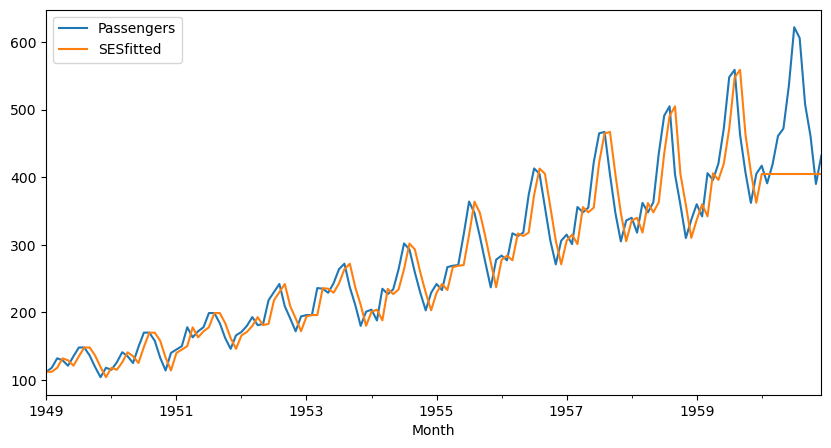

In [22]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)
df[['Passengers', 'SESfitted']].plot(figsize=(10,5));

In [23]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

#### Holt's Linear Trend Model

Este modelo expande o caso estudado no Simple Exponential Smoothing. Antes fazíamos previsões considerando valores constantes, mas agora consideramos uma tendência linear.

**Modelo na forma de componentes:**


Forecast Equation: $\hat{y}_{t+h\vert t} = l_t + h b_t$, para $h=1,2,3,\ldots$

Level Equation: $l_t = \alpha y_t + (1-\alpha) (l_{t-1} + b_{t-1})$.

Trend Equation: $b_t = \beta (l_t - l_{t-1}) + (1- \beta)b_{t-1}$.

Os parâmetros $\alpha$ e $\beta$ podem ser escolhidos de forma que minimizem o erro $$\sum_{t=1}^{T} (y_t - \hat{y}_{t \vert t-1})^2$$

In [24]:
from statsmodels.tsa.holtwinters import Holt

In [25]:
holt = Holt(df['Passengers'], initialization_method = 'legacy-heuristic')

In [26]:
res_h = holt.fit()

In [27]:
df['Holt'] = res_h.fittedvalues

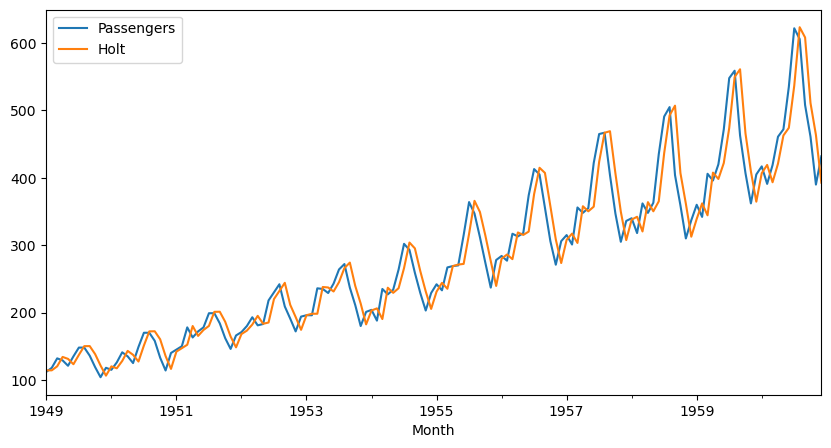

In [28]:
df[['Passengers', 'Holt']].plot(figsize=(10,5));

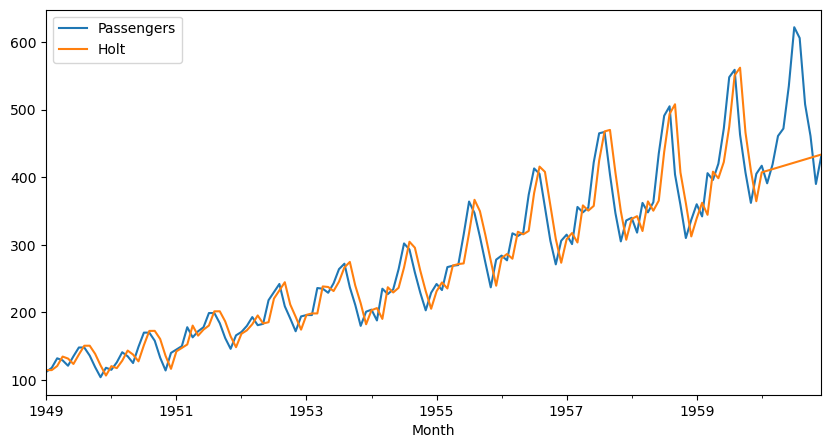

In [29]:
# rodando o modelo na nossa divisão treino/teste
holt = Holt(train['Passengers'], initialization_method = 'legacy-heuristic')
res_h = holt.fit()

df.loc[train_idx,'Holt'] = res_h.fittedvalues
df.loc[test_idx,'Holt'] = res_h.forecast(N_test)

df[['Passengers','Holt']].plot(figsize=(10,5));

#### Holt-Winters model

Aqui tratamos de um modelo adequado para modelar séries decompostas:

* Em uma tendência (linear);
* Em sazonalidade (ciclos);
* Em level (média), valor sobre o qual os outros termos flutuam.


**os modelos podem ser classificados em:** 
* Aditivos: y = level + tendência + sazonalidade
* Multiplicativos: y = (level + tendência)x sazonalidade

#### Modelo Holt-Winters Aditivo:

Forecast Equation: $\hat{y}_{t+h\vert t} = l_t + h b_t + s_{t + h - mk}$ onde $m$ é o período do ciclo (quanto demora para se repetir), $k = \lfloor \frac{h-1}{m}\rfloor + 1.$

Level Equation: $l_t = \alpha (y_t - s_{t-m}) + (1-\alpha) (l_{t-1} + b_{t-1})$.

Trend Equation: $b_t = \beta (l_t - l_{t-1}) + (1- \beta)b_{t-1}$.

Seasonal Equation: $s_t = \gamma (y_t - l_{t-1} - b_{t-1}) + (1 + \gamma)s_{t-m}$.

#### Modelo Holt-Winters Multiplicativo:

Forecast Equation: $\hat{y}_{t+h\vert t} = ( l_t + h b_t )s_{t + h - mk}$

Level Equation: $l_t = \alpha (\frac{y_t}{s_{t-m}}) + (1-\alpha) (l_{t-1} + b_{t-1})$.

Trend Equation: $b_t = \beta (l_t - l_{t-1}) + (1- \beta)b_{t-1}$.

Seasonal Equation: $s_t = \gamma (\frac{y_t}{l_{t-1} + b_{t-1}}) + (1 + \gamma)s_{t-m}$.

In [30]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [31]:
hw = ExponentialSmoothing(train['Passengers'], initialization_method = 'legacy-heuristic',
                          trend='add',seasonal='mul',seasonal_periods=12)

res_h = hw.fit()

In [32]:
df.loc[train_idx, 'HoltWinters'] = res_h.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_h.forecast(N_test)

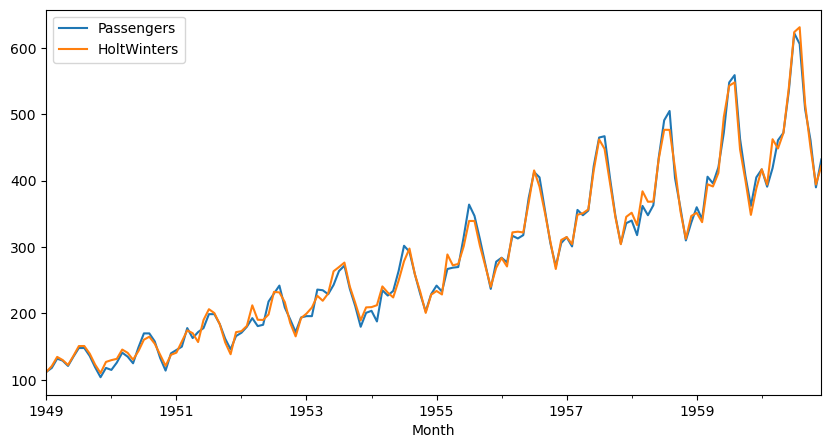

In [33]:
df[['Passengers','HoltWinters']].plot(figsize=(10,5));

In [34]:
def rmse(y,t):
    return np.sqrt(np.mean((y-t)**2))

In [35]:
print('Train RMSE:', rmse(train['Passengers'], res_h.fittedvalues))
print('Test RMSE:', rmse(test['Passengers'], res_h.forecast(N_test)))

Train RMSE: 9.768020481856626
Test RMSE: 15.809890178532703
